In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import itertools
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

nltk.download('brown')
nltk.download('stopwords')
stopwords = stopwords.words('english')

np.set_printoptions(suppress=True)

[nltk_data] Downloading package brown to /Users/r0g06z5/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/r0g06z5/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# info

# number of training epochs for Sparse LSA
n_epochs = 4000

# number of documents to consider
n_docs = 10

# number of topics
n_topics = 5

seed = 42

In [3]:
np.random.seed(seed)
brown = nltk.corpus.brown
docs = np.random.choice(brown.fileids(), n_docs, replace=False)

print('Processing sentences..\n')
processed_docs = {}
for doc in docs:
    processed_sents = []
    sents = brown.sents(doc)
    for sent in sents:
        processed_sents.append([word.lower() for word in sent if word.isalnum() and word not in stopwords])
    processed_docs[doc] = processed_sents

processed_sents = list(itertools.chain(*list(processed_docs.values())))
final_tokens = list(set(itertools.chain(*processed_sents)))
n_tokens = len(final_tokens)

token2int = dict(zip(final_tokens, range(n_tokens)))
int2token = {v:k for k,v in token2int.items()}

print('Number of Documents:', n_docs) 
print('Number of Tokens:', n_tokens)    

Processing sentences..

Number of Documents: 10
Number of Tokens: 4447


In [4]:
def get_frequency_hash_map(tokens):
    token_frequency_dict = {}
    all_tokens = list(itertools.chain(*tokens))
    for token in all_tokens:
        if token_frequency_dict.get(token):
            token_frequency_dict[token] +=1
        else:
            token_frequency_dict[token] = 1
    return token_frequency_dict

In [5]:
def build_term_document_matrix(processed_docs):
    term_document_matrix = np.zeros((n_docs, n_tokens), dtype='int')
    for doc_idx, doc in enumerate(processed_docs):
        tokens = processed_docs[doc]
        token_frequency_dict = get_frequency_hash_map(tokens)
        token_idxs = list(map(lambda x: token2int[x], token_frequency_dict.keys()))
        counts = list(token_frequency_dict.values())        
        term_document_matrix[doc_idx, token_idxs] = counts
    assert term_document_matrix.shape == (n_docs, n_tokens)        
    return term_document_matrix

In [6]:
def get_singular_value_decomposition(term_document_matrix, n_topics):
    U, S, VT = np.linalg.svd(term_document_matrix)
    
    """
    Necessary checks for Singular Value Decomposition:

    1. U and V are singular matrices
    2. Number of eigenvalues is rank of matrix 
    """

    assert np.allclose(U.T @ U, np.identity(len(U)))
    assert np.allclose(VT @ VT.T, np.identity(len(VT)))
    assert len(S) == np.linalg.matrix_rank(term_document_matrix)
    
    # low-rank approximation
    approximated_mat = U[:,:n_topics] @ np.diag(S[:n_topics]) @ VT[:n_topics]
    assert approximated_mat.shape == term_document_matrix.shape

    # projection matrix
    projection_mat = np.linalg.inv(np.diag(S[:n_topics])) @ VT[:n_topics]
    assert projection_mat.shape == (n_topics, n_tokens)
    return approximated_mat, projection_mat

In [7]:
print('Building Term Document Matrix..')
term_document_matrix = build_term_document_matrix(processed_docs)

print('Getting document representations in topic space (instead of original word space)..')
approximated_mat, projection_mat = get_singular_value_decomposition(term_document_matrix, n_topics)

Building Term Document Matrix..
Getting document representations in topic space (instead of original word space)..


Let's look at similarities between document representations

In [8]:
csim = cosine_similarity(projection_mat)
assert np.allclose(csim, np.identity(n_topics))

This says that the document representations in latent topic space i.e. **topics embeddings** are orthogonal to each other. This means that the original documents selected comprised of topics different from each other. 

### Sparse LSA

In [9]:
def is_present(token, words):
    if token in words:
        return 1
    else:
        return 0

def get_present_label(doc):
    words = brown.words(doc)
    words = [word.lower() for word in words if word.isalnum() and word not in stopwords] 
    present_label = list(map(lambda x: is_present(x, words), final_tokens))
    return present_label
    
def get_term_freq(doc):
    words_doc = list(itertools.chain(*processed_docs[doc]))
    vocab_doc = set(words_doc)    

    term_freq_dict = dict(Counter(words_doc))
    term_freq_dict = {token2int[k]: v for k,v in term_freq_dict.items()}
    counts = np.zeros(n_tokens)

    term_freq_mat = np.array(sorted(list(zip(term_freq_dict.keys(), term_freq_dict.values()))))
    idxs = term_freq_mat[:, 0]
    values = term_freq_mat[:, 1]
    counts[idxs] = values
    return counts / len(vocab_doc)

In [10]:
# term frequency matrix
term_freq_mat = np.array(list(map(lambda x: get_term_freq(x), docs)))

# document frequency matrix
all_docs = brown.fileids()
doc_frequency_mat = np.array(list(map(lambda x: get_present_label(x), all_docs)))
idf = np.log(len(all_docs) / np.sum(doc_frequency_mat, axis=0))

# tf-idf matrix
tfidf_mat = term_freq_mat * idf
assert tfidf_mat.shape == (n_docs, n_tokens)

In [12]:
def loss_fn(X,U,A,lamda):
    return np.sum((X-U@A).T @ (X-U@A)) / 2 + lamda * np.sum(abs(A))

def gradient(X,U,A,reg_coef,lamda):
    dA = A - U.T @ X + lamda * np.sign(A)
    dU = 2 * reg_coef * U - X @ A.T
    return dA, dU

def sparse_LSA_optimization(X, alpha, lamda, reg_coef, eps):
    U = np.random.random((n_docs, n_topics))
    A = np.random.random((n_topics, n_tokens))
    dA = np.random.random(A.shape)
    dU = np.random.random(U.shape)

    costs = []
    n_iter = 0
    cost = 1
    convergence = 1
    while cost > eps:
        dA, dU = gradient(X,U,A,reg_coef,lamda)
        A-= alpha * dA
        U-= alpha * dU
        cost = loss_fn(X,U,A,lamda)

        if n_iter%100==0:
            print(f'Cost at {n_iter} iterations:', cost.round(3))
        
        costs.append(cost)
        n_iter += 1

        if n_iter>=n_epochs:
            convergence = 0
            break        

    if convergence:
        print(f'Converged in {len(costs)} epochs..')
    else:
        print(f'Training complete with {n_epochs} epochs..')
    return A, U, costs        

In [17]:
X = tfidf_mat
alpha = 0.001
lamda = 0.4
reg_coef = 0.5
eps = 0.01    

A, U, costs = sparse_LSA_optimization(X, alpha, lamda, reg_coef, eps)

Cost at 0 iterations: 214881471.019
Cost at 100 iterations: 204908614.662
Cost at 200 iterations: 165506784.467
Cost at 300 iterations: 118192023.981
Cost at 400 iterations: 75923756.914
Cost at 500 iterations: 44118607.366
Cost at 600 iterations: 23068927.917
Cost at 700 iterations: 10675119.929
Cost at 800 iterations: 4232345.179
Cost at 900 iterations: 1351843.321
Cost at 1000 iterations: 306094.961
Cost at 1100 iterations: 35119.2
Cost at 1200 iterations: 351.916
Cost at 1300 iterations: 63.608
Cost at 1400 iterations: 69.741
Cost at 1500 iterations: 70.362
Cost at 1600 iterations: 70.887
Cost at 1700 iterations: 71.189
Cost at 1800 iterations: 71.494
Cost at 1900 iterations: 71.855
Cost at 2000 iterations: 71.672
Cost at 2100 iterations: 71.905
Cost at 2200 iterations: 71.271
Cost at 2300 iterations: 71.701
Cost at 2400 iterations: 71.718
Cost at 2500 iterations: 72.055
Cost at 2600 iterations: 71.789
Cost at 2700 iterations: 71.707
Cost at 2800 iterations: 71.793
Cost at 2900 ite

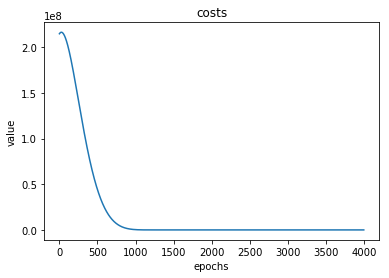

In [24]:
plt.plot(costs)
plt.title('costs')
plt.xlabel('epochs')
plt.ylabel('value')
plt.show()